# HW1: Handwritten Digit Recognition via Clustering Algorithm

Running K-Medoids on clean data...
Running K-Means on clean data...
(5, 784)


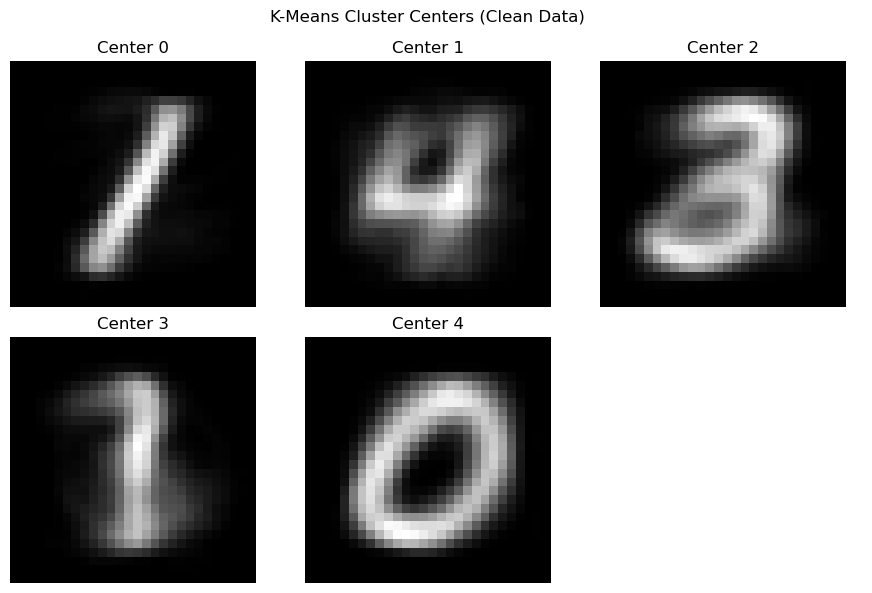

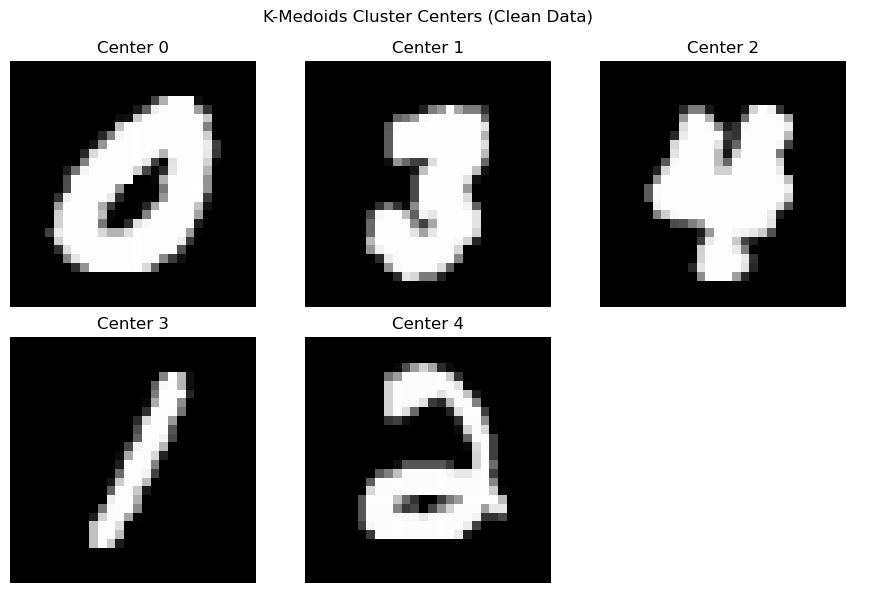

K-Medoids accuracy (clean data): 0.6880
K-Means accuracy (clean data): 0.6900
Adding contaminanted datapoints to the data...
Running K-Medoids on contaminated data...
Running K-Means on contaminated data...
K-Medoids accuracy (contaminated data): 0.6510
K-Means accuracy (contaminated data): 0.7370


In [35]:
import numpy as np
from utils import plot_cluster_centers, load_images_labels

MAX_ITER = 5000

def compute_dist(X, centers):
    """
    Compute the Euclidean distance between each point in X and each center in 'centers'.
    X: N x D
    centers: K x D
    Output: N x K matrix of distances
    """
    N, D = X.shape
    K = centers.shape[0]
    dist = np.sqrt(np.sum((X[:, np.newaxis, :] - centers[np.newaxis, :, :])**2, axis=2))
    return dist

def compute_cosine_dist(X, centers):

    X_norm = X / np.linalg.norm(X, axis=1, keepdims=True)
    centers_norm = centers / np.linalg.norm(centers, axis=1, keepdims=True)
    
    cosine_similarity = np.dot(X_norm, centers_norm.T)
    
    cosine_distance = 1 - cosine_similarity
    
    return cosine_distance


def compute_manhattan_dist(X, centers):

    manhattan_distance = np.sum(np.abs(X[:, np.newaxis, :] - centers[np.newaxis, :, :]), axis=2)
    
    return manhattan_distance


def mykmeans(digits, K):
    """
    Perform K-means clustering on 'digits' using K clusters.
    
    digits: (N, D) - N data points, each of dimension D = 784
    K: number of clusters
    max_iter: maximum number of iterations
    
    Returns:
      - cluster_assignments: (N,) array of cluster indices [0..K-1]
      - centers: (K, D) array of cluster centers
    """

    N = digits.shape[0]
    i=0
    # Random initialization using existing points
    initialize = np.random.choice(np.arange(N),K,False)
    centers = digits[initialize,:]
    cluster_assignment = []
    # Updating centroids
    while i<MAX_ITER:
        scores = compute_dist(digits,centers)
        cluster_assignment = np.argmin(scores,axis=1)
        for j in range(K):
            mask = cluster_assignment==j
            if np.any(mask): 
                centers[j, :] = np.mean(digits[mask, :], axis=0)
        i+=1
    return(cluster_assignment,centers)


def mykmedoids(digits, K):
    """
    Perform K-medoids clustering on 'digits' using K clusters.
    
    digits: (N, D) - N data points, each of dimension D = 784
    K: number of clusters
    max_iter: maximum number of iterations
    
    Returns:
      - cluster_assignments: (N,) array of cluster indices [0..K-1]
      - centers: (K, D) array of medoids (a subset of the original points)
    """
    N = digits.shape[0]
    i=0
    # Random initialization using existing points
    initialize = np.random.choice(np.arange(N),K,False)
    centers = digits[initialize,:]
    cluster_assignment = []
    # Updating centroids
    while i<MAX_ITER:
        scores = compute_cosine_dist(digits,centers)
        cluster_assignment = np.argmin(scores,axis=1)
        for j in range(K):
            mask = cluster_assignment == j
            if np.any(mask):
                cluster_points = digits[mask, :]
                cluster_dist = compute_cosine_dist(cluster_points, cluster_points)
                medoid = np.argmin(np.sum(cluster_dist, axis=1))
                centers[j, :] = cluster_points[medoid, :]
        i+=1
    return(cluster_assignment,centers)

def evaluate_clustering(cluster_assignments, labels, K):
    """
    Evaluate the clustering result by assigning each cluster to the most frequent 
    true label in that cluster, then compute the overall accuracy.
    
    cluster_assignments: (N,) array of cluster indices
    labels: (N,) array of true digit labels
    K: number of clusters
    Returns:
      accuracy (float)
    """
    correct = 0
    N = len(labels)
    
    for k in range(K):
        cluster_points_idx = np.where(cluster_assignments == k)[0]
        if len(cluster_points_idx) == 0:
            continue
        cluster_labels = labels[cluster_points_idx]
        most_common_label = np.bincount(cluster_labels).argmax()
        correct += np.sum(cluster_labels == most_common_label)
    
    accuracy = correct / N
    return accuracy


def main():
    # Load the data
    directory = "data"
    images, labels = load_images_labels(directory)
    
    # In case you get an out of memory error you may decrease N
    N = 1000
    images_subset = images[:N].astype(np.float32)
    labels_subset = labels[:N]
    
    K = 5  # Number of clusters

    # Apply K-Medoids on the clean data
    print("Running K-Medoids on clean data...")
    kmedoids_assignments, kmedoids_centers = mykmedoids(images_subset, K)

    # Apply K-Means on the clean data
    print("Running K-Means on clean data...")
    kmeans_assignments, kmeans_centers = mykmeans(images_subset, K)
    print(kmeans_centers.shape)

    # Plot cluster centers
    plot_cluster_centers(kmeans_centers, "K-Means Cluster Centers (Clean Data)", K)
    plot_cluster_centers(kmedoids_centers, "K-Medoids Cluster Centers (Clean Data)", K)

    # Evaluate clustering accuracy
    kmedoids_accuracy = evaluate_clustering(kmedoids_assignments, labels_subset, K)
    print(f"K-Medoids accuracy (clean data): {kmedoids_accuracy:.4f}")
    kmeans_accuracy = evaluate_clustering(kmeans_assignments, labels_subset, K)
    print(f"K-Means accuracy (clean data): {kmeans_accuracy:.4f}")

    # Add noisy contaminanted datapoints/outliers to the dataset
    print("Adding contaminanted datapoints to the data...")
    num_outliers = 100
    image_size = images_subset.shape[1]
    outliers = np.random.randint(0, 256, size=(num_outliers, image_size)).astype(np.float32)
    images_contaminated = np.vstack([images_subset, outliers])
    labels_contaminated = np.hstack([labels_subset, -1 * np.ones(num_outliers, dtype=int)])
    print("Running K-Medoids on contaminated data...")
    kmedoids_assignments_cont, kmedoids_centers_cont = mykmedoids(images_contaminated, K)
    print("Running K-Means on contaminated data...")
    kmeans_assignments_cont, kmeans_centers_cont = mykmeans(images_contaminated, K)
    
    # Evaluate clustering accuracy after contamination
    mask_no_outliers = labels_contaminated != -1
    kmedoids_accuracy_cont = evaluate_clustering(kmedoids_assignments_cont[mask_no_outliers], labels_contaminated[mask_no_outliers], K)
    print(f"K-Medoids accuracy (contaminated data): {kmedoids_accuracy_cont:.4f}")
    kmeans_accuracy_cont = evaluate_clustering(kmeans_assignments_cont[mask_no_outliers], labels_contaminated[mask_no_outliers], K)
    print(f"K-Means accuracy (contaminated data): {kmeans_accuracy_cont:.4f}")

if __name__ == "__main__":
    main()